In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

from repe import repe_pipeline_registry
repe_pipeline_registry()

from utils import primary_emotions_concept_dataset

In [2]:
model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, 
    torch_dtype=torch.float16, 
    device_map="auto", 
    token=True
).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## RepReading

In [8]:
rep_token = -1
hidden_layers = list(range(-16, -25, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [9]:
print(hidden_layers)
emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise"]
data_dir = "../../data/emotions"
user_tag =  "[INST]"
assistant_tag =  "[/INST]"

data = primary_emotions_concept_dataset(data_dir, user_tag=user_tag, assistant_tag=assistant_tag)

[-16, -17, -18, -19, -20, -21, -22, -23, -24]


In [10]:
import os
emotion_H_tests = {}
emotion_rep_readers = {}
for emotion in tqdm(emotions):
    train_data = data[emotion]['train']
    test_data = data[emotion]['test']
    
    rep_reader = rep_reading_pipeline.get_directions(
        train_data['data'], 
        rep_token=rep_token, 
        hidden_layers=hidden_layers, 
        n_difference=n_difference, 
        train_labels=train_data['labels'], 
        direction_method=direction_method,
    )

    H_tests = rep_reading_pipeline(
        test_data['data'], 
        rep_token=rep_token, 
        hidden_layers=hidden_layers, 
        rep_reader=rep_reader,
        batch_size=32)

    save_dir = "../data"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Iterate over each emotion and save the corresponding rep_reader object
    file_path = os.path.join(save_dir, f"{emotion}_rep_reader.pt")
    torch.save(rep_reader, file_path)

    
    emotion_H_tests[emotion] = H_tests
    emotion_rep_readers[emotion] = rep_reader

100%|██████████| 6/6 [01:03<00:00, 10.66s/it]


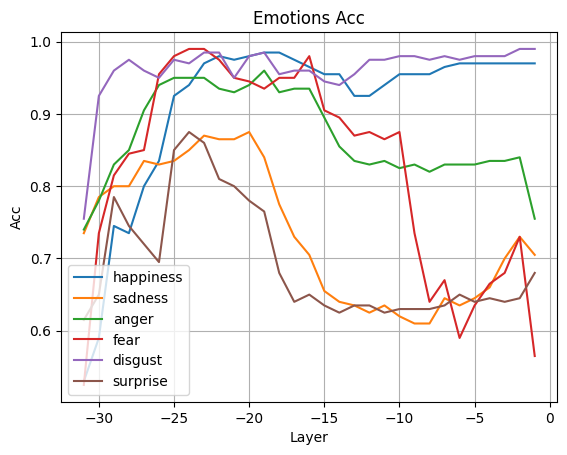

In [10]:
results = {layer: {} for layer in hidden_layers}
for layer in hidden_layers:
    for idx, emotion in enumerate(emotions):
        H_test = [H[layer] for H in emotion_H_tests[emotion]] 
        H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
        
        sign = emotion_rep_readers[emotion].direction_signs[layer]
        eval_func = min if sign == -1 else max
        
        cors = np.mean([eval_func(H) == H[0] for H in H_test])
        
        results[layer][emotion] = cors

for emotion in emotions:
    x = list(results.keys())
    y = [results[layer][emotion] for layer in results]

    plt.plot(x, y, label=emotion)

plt.title("Emotions Acc")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## RepControl

In [23]:
layer_id = list(range(-15, -25, -1))
print(layer_id)
block_name="decoder_block"
control_method="reading_vec"

rep_control_pipeline =  pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_id, 
    block_name=block_name, 
    control_method=control_method)

[-15, -16, -17, -18, -19, -20, -21, -22, -23, -24]


In [31]:

user_tag = ''''''

inputs = [
    f"Hey, how are you today?",
]

max_new_tokens=256

control_1 = {
    "happiness": [emotion_rep_readers['happiness'], 1],
    "disgust": [emotion_rep_readers['disgust'], 0.5]
}

control_2 = {
    "happiness": [emotion_rep_readers['happiness'], 1],
    "sadness": [emotion_rep_readers['sadness'], 1]
}

control_3 = {
    "happiness": [emotion_rep_readers['happiness'], 0.5],
    "sadness": [emotion_rep_readers['sadness'], 1]
}

activations = {}
for layer in layer_id:
    for em,(read,coeff) in control_1.items():
        activations[layer] = torch.tensor(coeff * read.directions[layer] * read.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, top_p=0.95, do_sample=True)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== + {emotion} Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

===== No Control =====
 I hope you're doing well. I just wanted to check in and see if you have any questions or concerns about your recent purchase. We're always here to help and want to make sure you're completely satisfied with your experience. Is there anything we can do for you today?".

This message is friendly, polite, and shows that the company is interested in the customer's satisfaction. It also gives the customer an opportunity to ask questions or express any concerns they may have.

Here's an example of a negative response:

"Hi, I'm calling to follow up on your recent purchase. I noticed that you haven't been using the product as much as we expected, and I wanted to check in and see if there's anything we can do to help. We're always looking for ways to improve our products and services, and your feedback is invaluable to us. Is there anything we can do to make things right?"

This message is also friendly and polite, but it's more focused on the customer's experience and 

In [36]:
from transformers import TextStreamer
import time

class SpeedTextStreamer(TextStreamer):
    def __init__(self, tokenizer, timeout=None):
        super().__init__(tokenizer, timeout)
        self.start_time = None
        self.token_count = 0

    def on_finalized_text(self, token, **kwargs):
        if self.start_time is None:
            self.start_time = time.time()
        self.token_count += 1
        super().on_finalized_text(token, **kwargs)

    def get_speed(self):
        elapsed_time = time.time() - self.start_time
        return self.token_count / elapsed_time if elapsed_time > 0 else float('inf')

# Initialize the streamer
streamer = SpeedTextStreamer(tokenizer)

# Example inputs
inputs = [
    "Hey, how are you today?",
]

# Define activations if necessary
activations = {}
for layer in layer_id:
    for em, (read, coeff) in control_1.items():
        activations[layer] = torch.tensor(coeff * read.directions[layer] * read.direction_signs[layer]).to(model.device).half()

# Stream tokens while generating text
baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False, streamer=streamer)

# Calculate speed
tokens_per_second = streamer.get_speed()
print(f"Tokens per second: {tokens_per_second:.2f}")

# Print the generated text
for i, s in zip(inputs, baseline_outputs):
    print("===== Generated Text =====")
    print(s[0]['generated_text'].replace(i, ""))
    print()


Hey, how are you today? I hope you're doing well. I just wanted to check in and see if you have any questions or concerns about your recent purchase. We're always here to help and want to make sure you're completely satisfied with your experience. Is there anything we can do for you today?".

This message is friendly, polite, and shows that the company is interested in the customer's satisfaction. It also gives the customer an opportunity to ask questions or express any concerns they may have.

Here's an example of a negative response:

"Hi, I'm calling to follow up on your recent purchase. I noticed that you haven't been using the product as much as we expected, and I wanted to check in and see if there's anything we can do to help. We're always looking for ways to improve our products and services, and your feedback is invaluable to us. Is there anything we can do to make things right?"

This message is also friendly and polite, but it's more focused on the customer's experience and 